# Predicting Bike Rentals

Machine Learning technique used in this project: Linear Regression, Decision Trees, Random Forests

## Introduction
Bike Rental companies are getting more and more popular in many cities around the world. This is especially true in many American metro cities. These companies have sharing stations set up throughout each respective city where riders can rent bikes by the hour or day, and return them conveniently to any sharing station in the city. 

We'll be focusing on Washington DC in this project, and using data collected from its bike rentals from 2011-2013. The data is compiled into a csv (17380 rows) by USC and can be found here: http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset.

Here are the columns that it contains:
* instant - A unique sequential ID number for each row
* dteday - The date of the rentals
* season - The season in which the rentals occurred
* yr - The year the rentals occurred
* mnth - The month the rentals occurred
* hr - The hour the rentals occurred
* holiday - Whether or not the day was a holiday
* weekday - The day of the week (as a number, 0 to 7)
* workingday - Whether or not the day was a working day
* weathersit - The weather (as a categorical variable)
* temp - The temperature, on a 0-1 scale
* atemp - The adjusted temperature
* hum - The humidity, on a 0-1 scale
* windspeed - The wind speed, on a 0-1 scale
* casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
* registered - The number of registered riders (people who had already signed up)
* cnt - The total number of bike rentals (casual + registered)

The goal of this project will be to try to predict the number of bikes people rent in any given hour. We'll be trying to predict the 'cnt' column in this case, using all of the other columns (except 'casual' and 'registered', as they do not look very useful). 

To accomplish this, we will apply a few different ML models to the data and see their performance, with the ultimate goal of applying a random forests ML model by the end.

## Basic Exploration
First, let's get our dataset into a readable format and do some basic analysis.

In [1]:
# get necessary modules
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# get our main df
bike_rentals = pd.read_csv("bike_rental_hour.csv")

# get the average rentals per day
ave = bike_rentals['cnt'].mean()
print(ave)

# look at last few rows
bike_rentals.tail()

189.46308763450142


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61
17378,17379,2012-12-31,1,1,12,23,0,1,1,1,0.26,0.2727,0.65,0.1343,12,37,49


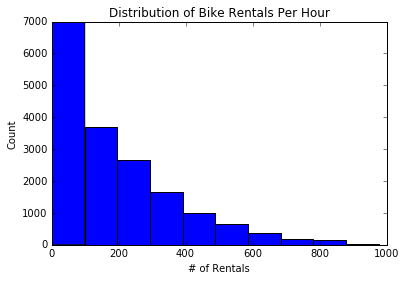

In [3]:
# make a histogram of distribution of rentals
plt.hist(bike_rentals['cnt'])
plt.title("Distribution of Bike Rentals Per Hour")
plt.xlabel("# of Rentals")
plt.ylabel("Count")
plt.show()

In [4]:
# see some correlations to the total rentals
bike_rentals.corr('pearson')["cnt"]

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

We see a basic normal curve in terms of rental distribution, which is good and expected. We also saw some basic interesting correlations to the total rentals that are worth keeping in mind. 

This also helps validate the data a little bit, due to us expecting a bell curve as well as categories like outside temp having a little correlation shown, whereas categories like the day being  holiday should not really have a correlation to rentals.

## Calculating Features
Before applying any ML model techniques, enhancing feautures can be a good idea. This introduces "new" information in ways that can make the accuracy of models become more efficient. 

For example, the 'hr' column of the dataset contains the values 1-24, corresponding to a 24 hour clock. We can relabel these values into morning, afternoon, evening, and night labels accordingly. 

A machine will treat these values differently, and while it may be able to categorize the different hours into labels eventually, we probably know that 4pm correlates more to 1pm than it does 7pm already, so we can just do this ourselves. It takes a bit of intuition here.

In [5]:
# create function to assign hour labels
def assign_label(hour):
    if hour in range(6,12):
        return 1
    elif hour in range(12,18):
        return 2
    elif hour in range(18,24):
        return 3
    elif hour in range(0,6):
        return 4
    # account for misvalues
    else:
        return 0

In [6]:
# apply function to the hours
bike_rentals["time_label"] = bike_rentals["hr"].apply(lambda x: assign_label(x))

# confirm there were no faults
print(bike_rentals[bike_rentals["time_label"] == 0])

Empty DataFrame
Columns: [instant, dteday, season, yr, mnth, hr, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed, casual, registered, cnt, time_label]
Index: []


In [7]:
# confirm the new column values
bike_rentals[['time_label', 'hr']].head(10)

,time_label,hr
0,4,0
1,4,1
2,4,2
3,4,3
4,4,4
5,4,5
6,1,6
7,1,7
8,1,8
9,1,9


Now that we have that under our belt, we can move on to splitting the dataset up.

# Train and Test Set Splitting
Again, before we can apply any ML algorithms, we must have some train data and some test data to apply them too. Doing this right is extremely vital to the validation and accuracy testing process. 

If we don't split right, we can get an ususually low error rate that may not be the true error rate due to overfitting.

Also, we will want to choose a metric for evaluating here right now. It's all subjective (with a little bit of objectiveness), so again it is all intuition. For this project, mean squared error makes the most sense to evaluate our error. MSE works on continuous numeric data, which fits our data quite well.

Let's start by splitting train/test in a 80-20 relationship.

In [8]:
# get the 80% index of df
cutoff = int(bike_rentals.shape[0] * 0.8)

# set 80% of rows to train using sampling
# random state = 1 is set for documentation purposes - remove parameter in real life
train = bike_rentals.sample(n=cutoff, random_state=1)

# set the rest of the rows to test set
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

#  confirm size of each
print(train.shape[0])
print(test.shape[0])

13903
3476


We finally have everything set to start using some algorithms!

## Applying Linear Regression
Using linear regression seems to be a good start as many of our features seem to be highly correlated with our target 'cnt' column.

Linear regression works best when predictors are linearly correlated to the target - aka they do not change meaning when we combine them with each other. This method is good error-wise as well because it is fairly resistant to overfitting. 

However, this comes with being prone to underfitting (or not building a powerful enough model). This means although linear regression is quick and efficient, sometimes it may not be the most accurate option. It is something we'll have to look out for. 

As mentioned before, we'll ignore the 'casual' and 'registered' columns, because these columns can be used to directly derive 'cnt'. There's no use in predicting there because we would just add them together!

We're also going to choose to remove the instant, dteday, and holiday columns (subjective choices) from prediction. The first because a unique ID can't predict anything, the second because the date is aleady captured in other columns, and the third because holiday dips or surges will also be captured in the other time columns as well as the 'workingday' column, and we already saw before that this column was not very correlated with 'cnt' to begin with.

Hopefully these changes will make the model more accurate.

In [9]:
# get list of columns
features = list(bike_rentals.columns)

# remove what we don't want
features.remove("cnt")
features.remove("casual")
features.remove("registered")
features.remove("dteday")
features.remove("instant")
features.remove("holiday")

# get linear regression tools
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# generate linear regression instance
lr = LinearRegression()

# train the model
lr.fit(train[features], train[['cnt']])

# make predictions on test
predictions = lr.predict(test[features])

# calculate error and root
mse = mean_squared_error(test[['cnt']], predictions)
rmse = np.sqrt(mse)

# see the MSE and RMSE
print("MSE: ", mse, "\nRMSE: ", rmse)

MSE:  17070.031628725843 
RMSE:  130.65233112625984


The error is very high here (RMSE is over half what the average rentals per day looks like!), which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

We could continue to re-iterate our process and work on this error using linear regression, but look to the last project (predicting stock prices) for that. For now, we have our basic idea of a linear regression model and its limitations, so let's move on.

## Applying Decision Trees
Let's switch it up and use some decision trees now. The good news is the process is more or less the same as linear regression (Python-wise of course; the algorithms are NOT the same!). We can compare the error rate we get here to the RMSE and MSE from linear regression to determine which algorithm is better!

Decision trees tend to be a little more complex than linaer regression, which means that athough they do tend to be a little more accurate, they can take more time as well. This also means they are prone to overfitting data, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. 

Lastly, decision trees are also prone to instability - small changes in the input can result in a very different model. More accuracy comes with a price! We will have to watch out for all of these things.

In [10]:
# get decision tree tools
from sklearn.tree import DecisionTreeRegressor

# generate decision tree instance - no parameters at first
dt = DecisionTreeRegressor()

# train the model
dt.fit(train[features], train[['cnt']])

# make predictions on test
predictions = dt.predict(test[features])

# calculate error and root
mse2 = mean_squared_error(test[['cnt']], predictions)
rmse2 = np.sqrt(mse2)

# see the MSE and RMSE
print("MSE: ", mse2, "\nRMSE: ", rmse2)

MSE:  3504.6168009205985 
RMSE:  59.19980406150513


We already got a significant decrease in our error! Like we mentioned before though, it is best to hard-code the parameters of our tree class to both prevent overfitting and also to possibly reduce error if there is no overfitting.

In [11]:
# generate new decision tree instance
dt2 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=5)

# train the model
dt2.fit(train[features], train[['cnt']])

# make predictions on test
predictions = dt2.predict(test[features])

# calculate error and root
mse3 = mean_squared_error(test[['cnt']], predictions)
rmse3 = np.sqrt(mse3)

# see the MSE and RMSE
print("MSE: ", mse3, "\nRMSE: ", rmse3)

MSE:  3032.7946133413857 
RMSE:  55.07081453312077


These numbers are chosen arbitrarily and subjectively for the parameters, and playing around with them will prove to work best (there seems to be a lot of subjectiveness in ML - but that's the beauty of it! It is both a science and an art, and knowing your domain in experience can take you far). 

All in all, it turns out that by taking the nonlinear predictors into account (something linear regression couldn't do - or at least is not as good at doing), the decision tree regressor appears to have much higher accuracy than linear regression.

## Applying Random Forests
Finally, we can now apply the random forest algorithm to the dataset, which improves upon the decision tree algorithm.

Random forests tend to be much more accurate because of the way they are structured - they keep the same complexity of decision trees to have more accurate predictions, but also tend to overfit much less than decision trees because of the multiple "trees" involved (aka the name forest). 

Note: Being "much less" prone to overfitting does not mean rid of overfitting. They can still overfit, and sometimes because we think the likelihood is so small this makes it more dangerous because we are not accounting for it. It is important to thus keep the tuning of parameters in mind again.

In [12]:
# get random forest tools
from sklearn.ensemble import RandomForestRegressor

# generate random forest instance - no parameters at first
rf = RandomForestRegressor()

# train the model - we use ravel (converts to 1d array in np to avoid warnings)
rf.fit(train[features], np.ravel(train[['cnt']]))

# make predictions on test
predictions = rf.predict(test[features])

# calculate error and root
mse4 = mean_squared_error(test[['cnt']], predictions)
rmse4 = np.sqrt(mse4)

# see the MSE and RMSE
print("MSE: ", mse4, "\nRMSE: ", rmse4)

MSE:  2200.9612370828536 
RMSE:  46.914403300935774


As you can see, the random forest algorithm even without tuning parameters is still producing a better MSE than the decision tree algorithm with tuning! We still have to account for overfitting, though, and tune the parameters here further. We may even get the benefit of an even more reduced MSE: 

In [13]:
# generate new random forest instance
rf2 = RandomForestRegressor(max_depth=10, min_samples_leaf=5)

# train the model - we use ravel (converts to 1d array in np to avoid warnings)
rf2.fit(train[features], np.ravel(train[['cnt']]))

# make predictions on test
predictions = rf2.predict(test[features])

# calculate error and root
mse5 = mean_squared_error(test[['cnt']], predictions)
rmse5 = np.sqrt(mse5)

# see the MSE and RMSE
print("MSE: ", mse5, "\nRMSE: ", rmse5)

MSE:  2798.856470447644 
RMSE:  52.90421977921652


It turns out that tuning the parameters won't do much more reducing for the MSE, but that's fine because we already found out that the random forest algorithm in general reduced it a lot from decision trees. To check for overfitting, we can check the MSE of a prediction on the training set:

In [14]:
# make predictions on train
predictions = rf2.predict(train[features])

# calculate error and root
mse6 = mean_squared_error(train[['cnt']], predictions)
rmse6 = np.sqrt(mse6)

# see the MSE and RMSE
print("MSE: ", mse6, "\nRMSE: ", rmse6)

MSE:  2115.131479513016 
RMSE:  45.99055859100883


As shown, the training MSE is a little bit less than the test MSE, which may be some indication of overfitting. However, the training error rate is more or less always going to be less than the test error rate purely due to the nature of the model. 

Judging by the overall RMSE difference (again, a subjective judgement), we should be okay in terms of overfitting this time with this model.

We can also test overfitting with any of the other previous models as well this way if we wish. It is the same process, so all we would have to do is copy the code over. We just did it for the last iteration and final random forest model here to avoid redundancy. The final model managed to produce an RMSE of just around 50.

## Further Analysis / Next Steps
Like always, there are a few more things about the project we can do that will be described below...

## Additional Features
We calculated the "time_label" feature as an example of a way to make features 'better', but there are a few other ways to go about it too.

One such example is making an index - combining things such as temperature, humidity, and wind speed. This has already been done of course, because it's useful! Temperature + humidity is called the Heat Index, and temperature + wind speed is called the Wind Chill.

The formulas for Heat Index and Wind Chill look complicated, but they're really just plug and chug once you have them down. They can be found here:
https://en.wikipedia.org/wiki/Heat_index and https://www.calculator.net/wind-chill-calculator.html.

Our problem is, however, temperature is recorded in our dataset not as an absolute F or C, but as a relative number on a scale of 0 to 1. We have no way of knowing if 0 is actually 0 degrees or if 1 is 100 degrees, so these calculations may become a bit off. 

We'll use the alternative of just doing a basic weighting system to show how new features can be calculated from old ones. If we had the actual absolute temperatures, the process would be the same.

Thinking of arbitrary weights, we'll go with something like 50% atemp (adjusted temp), 10% temp, 30% humidity, and 10% wind speed for our very greatly named "Bike Feel Index". 

Temperature will account for 60% of the index because that is what people pay the most attention to, afterall. Humidity gets some weight because sometimes it can affect your decision to rent a bike, but not most of the time - hence 30%. And finaly, wind speed gets 10% weight because it is also an environmental factor but the least worrysome for renters in our opinion. We create the feature below:

In [19]:
# produce weighted column
bike_rentals['bike_feel_index'] = (bike_rentals['temp'] * 0.1) + (bike_rentals['atemp'] * 0.5) + (bike_rentals['hum'] * 0.3) + (bike_rentals['windspeed'] * 0.1)
            
# see the df again
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label,bike_feel_index
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4,0.41095
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4,0.39835
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4,0.39835
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4,0.39295
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4,0.39295


We can also use this as an example to redo our random forest model with the index: (We will re-import code in below to produce the train and test sets again with the new column)

In [20]:
# get the 80% index of df
cutoff = int(bike_rentals.shape[0] * 0.8)

# set 80% of rows to train using sampling
# random state = 1 is set for documentation purposes - remove parameter in real life
train = bike_rentals.sample(n=cutoff, random_state=1)

# set the rest of the rows to test set
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

#  confirm size of each
print(train.shape[0])
print(test.shape[0])

# get list of columns
features = list(bike_rentals.columns)

# remove what we don't want
features.remove("cnt")
features.remove("casual")
features.remove("registered")
features.remove("dteday")
features.remove("instant")
features.remove("holiday")

# remove columns our index replaced
features.remove("temp")
features.remove("atemp")
features.remove("hum")
features.remove("windspeed")

13903
3476


In [23]:
# generate new random forest instance
rf3 = RandomForestRegressor(max_depth=15, min_samples_leaf=5)

# train the model - we use ravel (converts to 1d array in np to avoid warnings)
rf3.fit(train[features], np.ravel(train[['cnt']]))

# make predictions on test
predictions = rf3.predict(test[features])

# calculate error and root
mse7 = mean_squared_error(test[['cnt']], predictions)
rmse7 = np.sqrt(mse7)

# see the MSE and RMSE
print("MSE: ", mse7, "\nRMSE: ", rmse7)

MSE:  2688.147535345936 
RMSE:  51.84734839262212


As we can see, it helped a tiny tiny bit, but not much. We can't really expect groundbreaking moves from a simple weighting, even though sometimes it will make a lot of sense and actually do so. This was just an example.

If anything, we managed to eliminate the number of features we had by 3 and still got the same results, so at least this is good. It is always better to be simple, all other things being equal. If we had actual absolute temperatures, perhaps using the Heat Index and Wind Chill would have produced optimal results.

## Predicting Other Things
If we wanted to, we could try and predict the number of casual or registered riders instead of total renters. The process for this will actually be almost exactly the same, so we'll save the redundancy. A quick example for predicting casual will be below just for show. It's the same code, with a few things adjusted.

In [24]:
# retrain previous model
rf3.fit(train[features], np.ravel(train[['casual']]))

# make predictions on test
predictions = rf3.predict(test[features])

# calculate error and root
mse8 = mean_squared_error(test[['casual']], predictions)
rmse8 = np.sqrt(mse8)

# see the MSE and RMSE
print("MSE: ", mse8, "\nRMSE: ", rmse8)

MSE:  318.1132791301953 
RMSE:  17.8357304064116


The RMSE is a lot less, but this is because the average number of casual riders is also a lot less, so it is accounted for:

In [25]:
print(bike_rentals['casual'].mean())

35.67621842453536


## Conclusion
To sum everything up, in this project we used a few ML algorithms to build models that would predict the number of bike rentals in Washington DC. We determined that the random forest algorithm worked best for this dataset, and could get a prediction that wasn't *terrible*.

This was also a basis to show the pros and cons of basic linear regression vs. neural network algorithms like decision trees and random forests. While linear regression is very quick and efficient, sometimes it wll underfit and may not be as accurate. On the other hand, trees and forests are much more complex and thus more accurate, but this also makes them prone to overfitting. 

We can probably get this prediction down to just a few dozen rentals at most if we did things like more complex features, incorporating another dataset, adjusted a few more parameters, etc. The point is, all the tools we have are right there to build a successful model. Nothing is out of reach at this point! However, we have to be sure to understand the fundamentals of the math. No one can just pick up these models and go to town (well, they *can*, but if something goes wrong, it'll probably be a nightmare).